# Assignment: Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications, Spring 2022**<br>
31.03.2022<br>
Daniel Ridzon, Melany Marcias, Ha Do<br>
Metropolia University of Applied Sciences

## Introduction

In this notebook we will create 3 different neural network models for processing text reviews of drugs and from them we will predict numeric score which drug users included with the review.

## Detailed task assignment
> Your task is to use the methods of text processing and to experiment with recurrent and/or
convolutional (1D) neural networks to create a classifier for a collection of patient drug reviews
extracted from Drugs.com. Drugs.com is a comprehensive source of drug information online.
The original dataset is explained in Grässer et al (2018) article.

>The task is to build a classifier to address the following question:
>- Can you predict the rating of the drug based on the review?

>Following the article mentioned above, simplify the rating labels down to just three different
classes: “negative” (rating < 5), “neutral” (rating 5 or 6) and “positive” (rating > 6). After this,
**you should build a multiclass classifier to predict these three classes (negative, neutral, positive)
from the content of the written review.**

>To assess the performance of your classifier, you should evaluate your model with test data,
and present the full confusion matrix together with the classification report and the most
relevant metrics (accuracy + Cohen’s kappa) of this evaluation, with appropriate interpretations
(compare your results to the original article, Grässer et al. Table 2, p. 124).

>Download the KUC Hackathon Winter 2018 dataset from the Hackathon’s homepage:
https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018 or use the Kaggle
environment to build your Notebook. The dataset is already split into training and test sets. Use
pandas to read the data.

(recurrent NN)

# Implementation

## Importing required libraries

In [24]:
import numpy as np
import pandas as pd
import keras
import matplotlib
import nltk
import time
import csv
import tensorflow as tf

from matplotlib import style, pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Embedding, Dropout, SimpleRNN, Flatten, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from warnings import simplefilter

style.use("ggplot")

print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"nltk: {nltk.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"keras: {keras.__version__}")

numpy: 1.20.3
pandas: 1.3.4
matplotlib: 3.4.3
nltk: 3.6.5
tensorflow: 2.7.0
keras: 2.7.0


## Constants

In [2]:
# Training settings
random_seed = 42
VERBOSE = 1  # 0 to turn of debugging messages while training.
EPOCHS = 20  # number of epochs per model training.
BATCH_SIZE = 512

# Ignore tf performance warnings
simplefilter(action='ignore', category=FutureWarning)

## Load the dataset

In [3]:
# Load the dataset into the pandas dataframe object.
df_test = pd.read_csv("drugsComTest_raw.csv", sep=",", engine="python", quoting=csv.QUOTE_ALL)
df_train = pd.read_csv("drugsComTrain_raw.csv", sep=",", engine="python", quoting=csv.QUOTE_ALL)

# df_train = df_train.sample(15000, random_state = random_seed)  # TODO delete for final training

# Print info about the dataset.
print(f"Train dataset\n{df_train.describe().T}\n\n")
print(f"Test dataset\n{df_test.describe().T}")

Train dataset
                count           mean           std  min      25%       50%  \
uniqueID     161297.0  115923.585305  67004.445170  2.0  58063.0  115744.0   
rating       161297.0       6.994377      3.272329  1.0      5.0       8.0   
usefulCount  161297.0      28.004755     36.403742  0.0      6.0      16.0   

                  75%       max  
uniqueID     173776.0  232291.0  
rating           10.0      10.0  
usefulCount      36.0    1291.0  


Test dataset
               count           mean           std  min      25%       50%  \
uniqueID     53766.0  116386.701187  67017.739881  0.0  58272.5  116248.5   
rating       53766.0       6.976900      3.285207  1.0      4.0       8.0   
usefulCount  53766.0      27.989752     36.172833  0.0      6.0      16.0   

                   75%       max  
uniqueID     174586.75  232284.0  
rating           10.00      10.0  
usefulCount      36.00     949.0  


In [4]:
df_train.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


### Basic dataset observations
Training dataset has 161 000 samples and test dataset has 53 000 samples.  

Dataset also contains columns which we don't need, so we will drop them in the next phase. After that we will rescale rating column so it ranges just between categories 0, 1 and 2. (1-4: 0, 5-7: 1, 8-10: 2)

## Preprocessing

### Dropping useless columns
Here we dropped every column except review and rating from the dataset, as we don't need them.

In [5]:
df_train = df_train[["review", "rating"]]
df_test = df_test[["review", "rating"]]

df_train.head(5)

,review,rating
0,"""It has no side effect, I take it in combinati...",9
1,"""My son is halfway through his fourth week of ...",8
2,"""I used to take another oral contraceptive, wh...",5
3,"""This is my first time using any form of birth...",8
4,"""Suboxone has completely turned my life around...",9


### Convert rating values to 3 categories
At this phase we converted rating column from range 1-10 to 0-2

In [6]:
# Function to convert the values to categories
def convert_rating(rating):
    
    if rating < 5:
        return 0
    
    if rating >= 8:
        return 2

    return 1


# Apply the function
df_train["rating"] = df_train.apply(lambda row : convert_rating(row["rating"]), axis = 1)
df_test["rating"] = df_test.apply(lambda row : convert_rating(row["rating"]), axis = 1)

# Convert column to categorical
df_train["rating"] = df_train.rating.astype("category")
df_test["rating"] = df_test.rating.astype("category")

# Check the result
df_train.head(5)

,review,rating
0,"""It has no side effect, I take it in combinati...",2
1,"""My son is halfway through his fourth week of ...",2
2,"""I used to take another oral contraceptive, wh...",1
3,"""This is my first time using any form of birth...",2
4,"""Suboxone has completely turned my life around...",2


### Rating distribution after categorizing ratings.

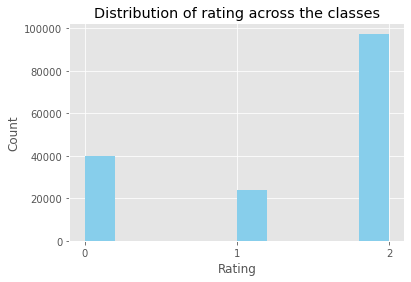

In [7]:
df_train.rating.hist(color="skyblue")
plt.title("Distribution of rating across the classes")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks([i for i in range(0, 3)])
plt.show()

#### Rating distribution observation
Target classes are not equally distributed, we will need to account for this training the model, by using class weights.  
Next we will compute the class weights.

In [8]:
cnt_all = df_train["rating"].count()
cnt_0 = df_train["rating"].value_counts().sort_index(ascending=True)[0]
cnt_1 = df_train["rating"].value_counts().sort_index(ascending=True)[1]
cnt_2 = df_train["rating"].value_counts().sort_index(ascending=True)[2]

print(f"all: {cnt_all}, 0: {cnt_0}, 1: {cnt_1}, 2: {cnt_2}")

class_weights = {
    0: 1 - cnt_0 / cnt_all,
    1: 1 - cnt_1 / cnt_all,
    2: 1 - cnt_2 / cnt_all
}

class_weights

all: 161297, 0: 40075, 1: 23812, 2: 97410


{0: 0.7515452860251586, 1: 0.852371711811131, 2: 0.3960830021637104}

### Split dataframes to Features and Labels

In [9]:
train_features = df_train.copy()
test_features = df_test.copy()

train_labels = np.array(train_features.pop("rating"))
test_labels = np.array(test_features.pop("rating"))

print(train_features[:5])
print(train_labels[:5])

                                              review
0  "It has no side effect, I take it in combinati...
1  "My son is halfway through his fourth week of ...
2  "I used to take another oral contraceptive, wh...
3  "This is my first time using any form of birth...
4  "Suboxone has completely turned my life around...
[2 2 1 2 2]


### One hot encode the labels
Because the target class is categorical, we should one hot encode the target class.

In [10]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_labels[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


## Text preprocessing

### Tokenize the reviews
Now we will tokenize the reviews into tokens of length 1 (Each word will be one token).

In [11]:
%%time

# Define, how many tokens will fit inside the dictionary.
max_features = 5000

# Define how many tokens can fit inside one sequence. (How long review can we process).
sequence_length = 200

# Tokenize the text
samples = train_features["review"]
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(samples)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)

# Print out the number of unique tokens
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 51429 unique tokens.
Wall time: 18.1 s


### Padding sequences
We need to pad the tokenized reviews, so they all have the same amount of tokens.

In [12]:
data = pad_sequences(sequences, maxlen = sequence_length)
print(f"Shape of data tensor:{data.shape}")
print(data[1])

Shape of data tensor:(161297, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    6  638   19 3380  225  508 1652   76   12 3254  262
  404 1226   62  162  373   14  145   76   62  162   49   36    3 2311
  148  162   86   54   13    9  112   55  162  156  914   52   59   12
  333   10   57 3388    2  778    9  648  227  146   13    7  289  505
   61  512 2716   57 2133    9  533    1  651  508   78   13 1419  206
    2  229  272    4  784    5   59    7  126   55  215  217  162   87
   26  512    2   21  160   53   15    3  206    3  145  112   55   11
   25  299  387  162   19  102   71  106  169  162   19  261  532    7
  120  214  261 3388  162   19 2224   37    3  278  162  371  394  508
 1951   19  107   73  262   11  134  221  

## Modelling
In this example we created Sequential NN model, starting with embedding layer of 128 dimension. After this layer, we added .25 dropout layer and bidirectional SimpleRNN layer. After the RNN layer we added another .25 dropout layer and 1 hidden dense layer with 10 neurons.

In [16]:
embedding_dim = 128

model2 = Sequential([
    Embedding(max_features + 1, embedding_dim),
    Dropout(0.25),
    Bidirectional(SimpleRNN(units=embedding_dim, input_shape=(1,1), activation="relu")),
    Dropout(0.4),
    Flatten(),
    Dense(10, activation="relu"),
    Dense(3, activation = 'softmax')
])

# Compile
model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['acc']
)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640128    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              65792     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                        

## Training

In [17]:
%%time
history2 = model2.fit(
    data,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split=0.2,
    class_weight=class_weights,
    shuffle=True,
    verbose = VERBOSE,
)

Epoch 1/20
253/253 [==============================] - 363s 1s/step - loss: 0.5616 - acc: 0.6188 - val_loss: 0.8556 - val_acc: 0.6479
Epoch 2/20
253/253 [==============================] - 367s 1s/step - loss: 0.5057 - acc: 0.6918 - val_loss: 1.0421 - val_acc: 0.5520
Epoch 3/20
253/253 [==============================] - 386s 2s/step - loss: 0.4613 - acc: 0.7098 - val_loss: 0.7483 - val_acc: 0.7177
Epoch 4/20
253/253 [==============================] - 377s 1s/step - loss: 50253220.0000 - acc: 0.7241 - val_loss: 0.9231 - val_acc: 0.6869
Epoch 5/20
253/253 [==============================] - 386s 2s/step - loss: 0.4282 - acc: 0.7351 - val_loss: 0.8294 - val_acc: 0.6914
Epoch 6/20
253/253 [==============================] - 374s 1s/step - loss: 248.9549 - acc: 0.7002 - val_loss: 0.8197 - val_acc: 0.6714
Epoch 7/20
253/253 [==============================] - 357s 1s/step - loss: 120860408.0000 - acc: 0.6937 - val_loss: 0.6683 - val_acc: 0.7356
Epoch 8/20
253/253 [==============================] 

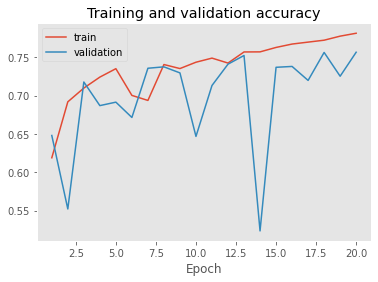

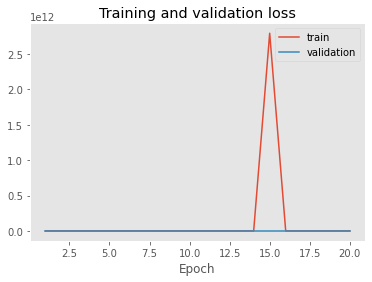

In [19]:
# Plot the accuracy and loss
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
e = np.arange(len(acc)) + 1

plt.plot(e, acc, label = 'train')
plt.plot(e, val_acc, label = 'validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.figure()

plt.plot(e, loss, label = 'train')
plt.plot(e, val_loss, label = 'validation')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

## Training observations
By using biderictional RNN we achieved validation accuracy of 75% on three class classifier.

## Save the model
Here we saved the NN model into export file, which can be later laoded

In [25]:
# Saving the model
model2.save("case_3_model_bidRNN.h5")

# Command for loading the model from the save file. 
model2_save = keras.models.load_model("case_3_model_bidRNN.h5")